In [1]:
from dotenv import load_dotenv
import os

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel
from langchain.schema import HumanMessage, AIMessage

from src.nodes import *
from src.state import State
from src.util import next_node
from src.main import ResumeAgent

In [2]:
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")
# print(os.environ["GOOGLE_API_KEY"])

In [3]:
gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.7)
evaluator = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.2)
aggregator = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.5)

In [4]:
# Config
max_iterations = 5

In [5]:
prompts = []
with open("./prompts/resume_p1_impact.txt") as f:
    prompts.append(f.read())
with open("./prompts/resume_p2_skills.txt") as f:
    prompts.append(f.read())
with open("./prompts/resume_p3_industry.txt") as f:
    prompts.append(f.read())

In [6]:
builder = StateGraph(State)

nodes = {
    "Supervisor": Supervisor(),
    "Agent1": Agent("Agent 1 - Impact", gemini, prompts[0]),
    "Agent2": Agent("Agent 2 - Skills", gemini, prompts[1]),
    "Agent3": Agent("Agent 3 - Industry", gemini, prompts[2]),
    "Aggregator": Aggregator(aggregator),
    "Evaluator": Evaluator(evaluator),
    "loop_control": LoopControlNode(max_iterations),
}

In [7]:
for name, node in nodes.items():
    builder.add_node(name, node)

In [8]:
# Define the flow
builder.add_edge(START, "Supervisor")

# Edges from Supervisor to Agents
builder.add_edge("Supervisor", "Agent1")
builder.add_edge("Supervisor", "Agent2")
builder.add_edge("Supervisor", "Agent3")

# Edges from Agents to Aggregator
builder.add_edge("Agent1", "Aggregator")
builder.add_edge("Agent2", "Aggregator")
builder.add_edge("Agent3", "Aggregator")

# Edge from Aggregator to Evaluator
builder.add_edge("Aggregator", "Evaluator")

# From Reviewer to Loop Control Node
builder.add_edge("Evaluator", "loop_control")

# Conditionally decide the next node from Loop Control Node
builder.add_conditional_edges("loop_control", next_node)

In [9]:
# Compile the graph
graph = builder.compile()

In [10]:
query = "Tailor the provided resume to the job description according to the given goal and instructions, also consider feedback if available."

In [11]:
with open("./sample_data/resume.txt", "r") as f:
    resume = f.read()
with open("./sample_data/jd.txt", "r") as f:
    job_description = f.read()

In [12]:
initial_state = State(
    messages=[HumanMessage(role="user", content=query)],
    iteration=0,
    resume=resume,
    job_description=job_description,
    agent_outputs=[],
    relevancy=0.0,
    continue_loop=True
)

In [13]:
final_state = graph.invoke(initial_state, {"recursion_limit": 500})

Node Supervisor processed


c:\Mihir\Projects\Resume_Tailoring_through_Feedback_Loop\src\nodes.py:53: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = self.llm(messages=[HumanMessage(role="user", content=prompt)])


Node Agent 3 - Industry processed
Node Agent 2 - Skills processed
Node Agent 1 - Impact processed
Aggregator Resume: Okay, here's a final resume combining the best elements from each of the agent outputs, aiming for maximum relevancy to a Snowflake Data Cloud Platform Engineer role, focusing on impact, skills, and alignment with the job description.

****

**MIHIR THAKUR**
602-576-4346 â‹„ Tempe, AZ
tmihir27@gmail.com â‹„ mik-27.github.io â‹„ Linkedin â‹„ GitHub

**OBJECTIVE**
Results-oriented graduate student with a passion for building scalable and secure data solutions. Proven ability to design and implement innovative applications leveraging machine learning, full-stack development, and cloud technologies, with a focus on trust and risk management, seeking a challenging role contributing to Snowflake's Data Cloud Platform Center.

**EDUCATION**
Arizona State University, Master of Science in Computer Science May 2025
Coursework: Statistical ML, NLP, Data Mining, Adv. Operating Syste

In [14]:
# for output in final_state['agent_outputs']:
#     print(output.content)

In [15]:
for output in final_state['messages']:
    print(output.content)

Tailor the provided resume to the job description according to the given goal and instructions, also consider feedback if available.
Iteration 0: Think before responding: Tailor the provided resume to the job description according to the given goal and instructions, also consider feedback if available.
Agent 1 - Impact response: Okay, I understand. I will tailor Mihir Thakur's resume to the Snowflake Data Cloud Platform Center role, emphasizing his experience with distributed systems, cloud services, security/governance (where applicable), database systems, ML/AI, and strong coding skills in Java, Python, and SQL. I will focus on quantifiable achievements and impact, while maintaining the original format and length.

Here's the revised resume:

**MIHIR THAKUR**
602-576-4346 â‹„ Tempe, AZ
tmihir27@gmail.com â‹„ mik-27.github.io â‹„ Linkedin â‹„ GitHub

**OBJECTIVE**
Results-oriented graduate student with a passion for building scalable and secure data solutions. Proven ability to design

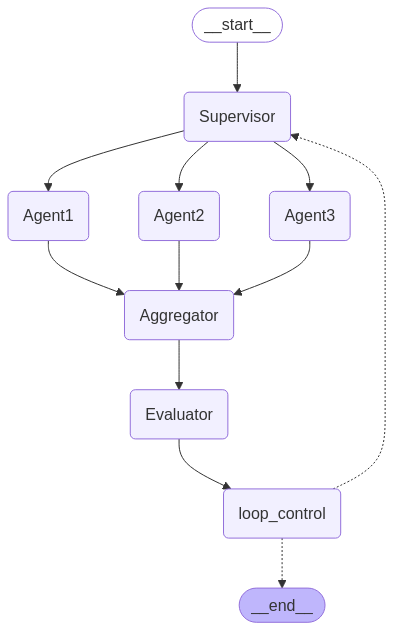

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [1]:
from src.main import ResumeAgent

query = "Tailor the provided resume to the job description according to the given goal and instructions, also consider feedback if available."
agent = ResumeAgent(query)

with open("./sample_data/resume.txt", "r") as f:
    resume = f.read()
with open("./sample_data/jd.txt", "r") as f:
    job_description = f.read()

res = agent.run(resume, job_description)
print(res['messages'][-1].content)

Node Supervisor processed


c:\Mihir\Projects\Resume_Tailoring_through_Feedback_Loop\src\nodes.py:57: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = self.llm(messages=[HumanMessage(role="user", content=prompt)])


Node Agent 2 - Skills processed
Node Agent 1 - Impact processed
Node Agent 3 - Industry processed
Node Aggregator processed
Node Evaluator processed

Iteration 1, Relevancy Score: 0.85
Continuing to the next iteration.
Node LoopControl processed
Node Supervisor processed
Node Agent 3 - Industry processed
Node Agent 1 - Impact processed
Node Agent 2 - Skills processed
Node Aggregator processed
Node Evaluator processed

Iteration 2, Relevancy Score: 0.87
Continuing to the next iteration.
Node LoopControl processed
Node Supervisor processed
Node Agent 3 - Industry processed
Node Agent 1 - Impact processed
Node Agent 2 - Skills processed
Node Aggregator processed
Node Evaluator processed

Iteration 3, Relevancy Score: 0.92
Relevancy score has reached threshold of 90. Terminating the process.
Node LoopControl processed
Review result: Feedback: The resume is strong and well-tailored to the job description. Here's a breakdown of areas for improvement and the rationale:

*   **Objective:** Whi